## Linear Regression Analysis of empirical and simulated transcript expression profiles


In this notebook I perform a simple linear regression analysis between an empirical transcript expression profile and its simulated counterpart in order to evaluate whether the RSDS simulator I developed is capable of reproducing a real expression profile in simulation. A transcript expression profile can be described as the collection of all identified transcripts following the alignment of RNA sequences to a reference genome or transcriptome alignment software such as STAR.  The total number of reads that match a given transcript is a measure of the relative expression of the particular transcript or gene in the biological sample. The quantification or counting of all the reads that matched a specific transcript or gene follows the alignment step and is done with quantification tools such as RSEM.

#### Dataset:

The dataset utilized for this evaluation is a publicly available RNA-seq dataset denoted as GC6 from here on. This dataset was downloaded from the Genome Expression Omnibus (GEO) accession number GSE94438. In this study RNA-based, gene expression biosignatures derived from whole-blood are described that predict infection with Mycobacterium tuberculosis in household contacts. RNA samples were depleted from globin transcripts followed by cDNA synthesis using Illumina TruSeq Stranded mRNA kit. RNA-seq was done on an Illumina HiSeq-4000 sequencer generating 50-bp paired-end reads with a sequencing depth of approximately 60 million reads.

#### Data pre-processing steps:

After downloading the raw RNA-seq dataset from the GEO database. The following steps was applied:

1. Quality check for raw RNA-seq dataset with `FASTQC` 
2. Alignment of RNA-seq reads (fastq files) to human reference genome GRCh37.8 
3. Quality check for aligned data with `RseQC`
4. Quantification analysis with `RSEM`
5. Generate a transcript expression model using `RSDS` built in function: `rsds-learn-profile`
6. Run simulation with parameter values similar to original experiment:
    - read length
    - sequencing depth 
    - Phred quality 
    - transcript expression model
    - fragment-length distribution model 
    - human reference transcriptome FASTA database

#### Analysis steps:

The following steps will be followed to compare the real data to the simulated data which will serve as a measure of the performance of the RSDS algorithm that is how well can the algorithm reproduce a given expression profile. 

1. Import the read count matrix as dataframes for the empirical and simulated datasets
2. Filter the dataframes by removing all rows that have 0 values in the IsoPct column
3. Check that all rows and columns consist of the right data formats
4. Perform linear regression analysis with scikit-learn package
5. Visualize output with seaborn and matplotlib
6. interpretation and summary


### Imports

I will be using the standard data science and machine-learning libraries: `numpy`, `pandas`, and `sckit-learn` as well as `matplotlib` and `seaborn` libraries for visualization.

In [1]:
import numpy as np
from pandas.plotting import table
import pandas as pd
import pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pickle
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import gzip

First I load both count matrices (tables) of the actual and simulated data as a Pandas dataframes which is sort of like a spreadsheet in Python. I then inspect a small subset of the data to determine the number of observations and to make sure that all the data have the appropriate data types. 

The data representing the truth, is denoted by the variable `df_ct` and the simulated data by `df_simct` 

From the inspection we see that each dataframe have `200468` observations respectively. This value does not reflect the true value of the total amount of transcripts in the sample as the RSEM tool used for quantification adds all the transcript that is present in the reference transcriptome file regardless of whether they have reads assigned to it. The transcripts that is not in the a actual biological sample have a isoform percentage of 0.00 denoted as IsoPct in the count matrix. I filter the dataframe by removing all observations (rows) that contain the value 0.00 in the IsoPct column.

After the filtering step the number of observations in the reference dataframe is `86103`  and the simulated, `83426` data points.




In [2]:
# Read the data into the dataframe
df_ct = pd.read_csv("SUN_control.isoforms.results", sep='\t')
# Display the first 10 lines of the dataframe
x = df_ct.head()
x

,transcript_id,gene_id,length,effective_length,expected_count,TPM,FPKM,IsoPct
0,ENST00000373020.8,ENSG00000000003.14,2206,2033.35,10.0,0.16,0.13,100.0
1,ENST00000494424.1,ENSG00000000003.14,820,647.37,0.0,0.00,0.00,0.0
2,ENST00000496771.5,ENSG00000000003.14,1025,852.35,0.0,0.00,0.00,0.0
3,ENST00000612152.4,ENSG00000000003.14,3796,3623.35,0.0,0.00,0.00,0.0
4,ENST00000614008.4,ENSG00000000003.14,900,727.36,0.0,0.00,0.00,0.0


In [3]:
df_ct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200468 entries, 0 to 200467
Data columns (total 8 columns):
transcript_id       200468 non-null object
gene_id             200468 non-null object
length              200468 non-null int64
effective_length    200468 non-null float64
expected_count      200468 non-null float64
TPM                 200468 non-null float64
FPKM                200468 non-null float64
IsoPct              200468 non-null float64
dtypes: float64(5), int64(1), object(2)
memory usage: 12.2+ MB


In [4]:
dfct = df_ct[df_ct.IsoPct != 0.00]
dfct.info()
dfct.reset_index(drop=True, inplace=True)
dfct.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86103 entries, 0 to 200466
Data columns (total 8 columns):
transcript_id       86103 non-null object
gene_id             86103 non-null object
length              86103 non-null int64
effective_length    86103 non-null float64
expected_count      86103 non-null float64
TPM                 86103 non-null float64
FPKM                86103 non-null float64
IsoPct              86103 non-null float64
dtypes: float64(5), int64(1), object(2)
memory usage: 5.9+ MB


,transcript_id,gene_id,length,effective_length,expected_count,TPM,FPKM,IsoPct
0,ENST00000373020.8,ENSG00000000003.14,2206,2033.35,10.00,0.16,0.13,100.00
1,ENST00000371582.8,ENSG00000000419.12,1161,988.35,9.97,0.32,0.27,3.23
2,ENST00000371584.8,ENSG00000000419.12,1073,900.35,61.01,2.14,1.80,21.72
3,ENST00000371588.9,ENSG00000000419.12,1075,902.35,164.28,5.76,4.83,58.36
4,ENST00000413082.1,ENSG00000000419.12,672,499.43,18.08,1.15,0.96,11.60


In [5]:
df_simct = pd.read_csv("simSUNcontrolprofile.isoforms.results", sep='\t')
df_simct.head()

,transcript_id,gene_id,length,effective_length,expected_count,TPM,FPKM,IsoPct
0,ENST00000373020.8,ENSG00000000003.14,2206,2027.98,17.0,0.21,0.17,100.0
1,ENST00000494424.1,ENSG00000000003.14,820,642.07,0.0,0.00,0.00,0.0
2,ENST00000496771.5,ENSG00000000003.14,1025,846.98,0.0,0.00,0.00,0.0
3,ENST00000612152.4,ENSG00000000003.14,3796,3617.98,0.0,0.00,0.00,0.0
4,ENST00000614008.4,ENSG00000000003.14,900,722.01,0.0,0.00,0.00,0.0


In [6]:
df_simct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200468 entries, 0 to 200467
Data columns (total 8 columns):
transcript_id       200468 non-null object
gene_id             200468 non-null object
length              200468 non-null int64
effective_length    200468 non-null float64
expected_count      200468 non-null float64
TPM                 200468 non-null float64
FPKM                200468 non-null float64
IsoPct              200468 non-null float64
dtypes: float64(5), int64(1), object(2)
memory usage: 12.2+ MB


In [7]:
dfsimct = df_simct[df_simct.IsoPct != 0.00]
dfsimct.reset_index(drop=True, inplace=True)
dfsimct.info()
dfsimct.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83426 entries, 0 to 83425
Data columns (total 8 columns):
transcript_id       83426 non-null object
gene_id             83426 non-null object
length              83426 non-null int64
effective_length    83426 non-null float64
expected_count      83426 non-null float64
TPM                 83426 non-null float64
FPKM                83426 non-null float64
IsoPct              83426 non-null float64
dtypes: float64(5), int64(1), object(2)
memory usage: 5.1+ MB


,transcript_id,gene_id,length,effective_length,expected_count,TPM,FPKM,IsoPct
0,ENST00000373020.8,ENSG00000000003.14,2206,2027.98,17.00,0.21,0.17,100.00
1,ENST00000371584.8,ENSG00000000419.12,1073,894.98,58.55,1.66,1.34,16.64
2,ENST00000371588.9,ENSG00000000419.12,1075,896.98,231.86,6.56,5.31,65.74
3,ENST00000413082.1,ENSG00000000419.12,672,494.35,31.50,1.62,1.31,16.21
4,ENST00000466152.5,ENSG00000000419.12,1097,918.98,5.09,0.14,0.11,1.41


I merge the two dataframes on the transcript id column so that the observations in both dataframes are equal. The total number of observations after the merge operation drops to `76172` values. The merged table consist of all the columns of the reference table as well as the columns of the simulated table. I added suffixes to each column name to identify the respective tables.

In [9]:
df_result = pd.merge(dfsimct, dfct, suffixes=('_sim', '_real'), left_on='transcript_id', right_on='transcript_id')
df_result.info()
df_result.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76172 entries, 0 to 76171
Data columns (total 15 columns):
transcript_id            76172 non-null object
gene_id_sim              76172 non-null object
length_sim               76172 non-null int64
effective_length_sim     76172 non-null float64
expected_count_sim       76172 non-null float64
TPM_sim                  76172 non-null float64
FPKM_sim                 76172 non-null float64
IsoPct_sim               76172 non-null float64
gene_id_real             76172 non-null object
length_real              76172 non-null int64
effective_length_real    76172 non-null float64
expected_count_real      76172 non-null float64
TPM_real                 76172 non-null float64
FPKM_real                76172 non-null float64
IsoPct_real              76172 non-null float64
dtypes: float64(10), int64(2), object(3)
memory usage: 9.3+ MB


,transcript_id,gene_id_sim,length_sim,effective_length_sim,expected_count_sim,TPM_sim,FPKM_sim,IsoPct_sim,gene_id_real,length_real,effective_length_real,expected_count_real,TPM_real,FPKM_real,IsoPct_real
0,ENST00000373020.8,ENSG00000000003.14,2206,2027.98,17.00,0.21,0.17,100.00,ENSG00000000003.14,2206,2033.35,10.00,0.16,0.13,100.00
1,ENST00000371584.8,ENSG00000000419.12,1073,894.98,58.55,1.66,1.34,16.64,ENSG00000000419.12,1073,900.35,61.01,2.14,1.80,21.72
2,ENST00000371588.9,ENSG00000000419.12,1075,896.98,231.86,6.56,5.31,65.74,ENSG00000000419.12,1075,902.35,164.28,5.76,4.83,58.36
3,ENST00000413082.1,ENSG00000000419.12,672,494.35,31.50,1.62,1.31,16.21,ENSG00000000419.12,672,499.43,18.08,1.15,0.96,11.60
4,ENST00000466152.5,ENSG00000000419.12,1097,918.98,5.09,0.14,0.11,1.41,ENSG00000000419.12,1097,924.35,14.65,0.50,0.42,5.08


In [10]:
dfr = df_result.filter(regex='_real', axis=1)
dfr = dfr.join(df_result['transcript_id'])
trancolumn = dfr.pop('transcript_id')
dfr.insert(0, 'transcript_id', trancolumn)
dfr.head()

,transcript_id,gene_id_real,length_real,effective_length_real,expected_count_real,TPM_real,FPKM_real,IsoPct_real
0,ENST00000373020.8,ENSG00000000003.14,2206,2033.35,10.00,0.16,0.13,100.00
1,ENST00000371584.8,ENSG00000000419.12,1073,900.35,61.01,2.14,1.80,21.72
2,ENST00000371588.9,ENSG00000000419.12,1075,902.35,164.28,5.76,4.83,58.36
3,ENST00000413082.1,ENSG00000000419.12,672,499.43,18.08,1.15,0.96,11.60
4,ENST00000466152.5,ENSG00000000419.12,1097,924.35,14.65,0.50,0.42,5.08


In [11]:
dfsim = df_result.filter(regex='_sim', axis=1)
dfsim.head()
dfsim = dfsim.join(df_result['transcript_id'])
dfsim
trancolumn = dfsim.pop('transcript_id')
dfsim.insert(0, 'transcript_id', trancolumn)
dfsim


,transcript_id,gene_id_sim,length_sim,effective_length_sim,expected_count_sim,TPM_sim,FPKM_sim,IsoPct_sim
0,ENST00000373020.8,ENSG00000000003.14,2206,2027.98,17.00,0.21,0.17,100.00
1,ENST00000371584.8,ENSG00000000419.12,1073,894.98,58.55,1.66,1.34,16.64
2,ENST00000371588.9,ENSG00000000419.12,1075,896.98,231.86,6.56,5.31,65.74
3,ENST00000413082.1,ENSG00000000419.12,672,494.35,31.50,1.62,1.31,16.21
4,ENST00000466152.5,ENSG00000000419.12,1097,918.98,5.09,0.14,0.11,1.41
...,...,...,...,...,...,...,...,...
76167,ENST00000641619.1,ENSG00000284735.1,917,739.00,2.00,0.07,0.06,40.54
76168,ENST00000641267.1,ENSG00000284738.1,1254,1075.98,55.00,1.30,1.05,91.54
76169,ENST00000641974.1,ENSG00000284740.1,660,482.39,9.75,0.51,0.41,100.00
76170,ENST00000641354.1,ENSG00000284747.1,2101,1922.98,10.00,0.13,0.11,48.67


Here I do further exploratory analysis to visually inspect the data. This is done to visualise the pattern the data conforms to. I do this by generating a scatter plot of the two datasets. The expected count column is of interest as these values represent the relative expression of the respective transcripts or isoforms and as a collective the respective genes.

The actual data(denoted as ''truth'') is plotted on the x-axis and the simulated data (denoted as ''simulated'') on the y-axis.

From the scatter plot we can see that almost all the observations follows a straight line and lies on a kind of slope. Some of the data points clearly deviates from this pattern.The deviated points will need further investigation. From this plot we can can see that most of the observations populate at the lower part of the figure and as we move along the x- axis the cloud of data gradually thins out with one spot right at the extreme. The most dense part of the plot falls between 0 and 150000. 

It is also important to note that one point on the graph can represent more than one data value. 


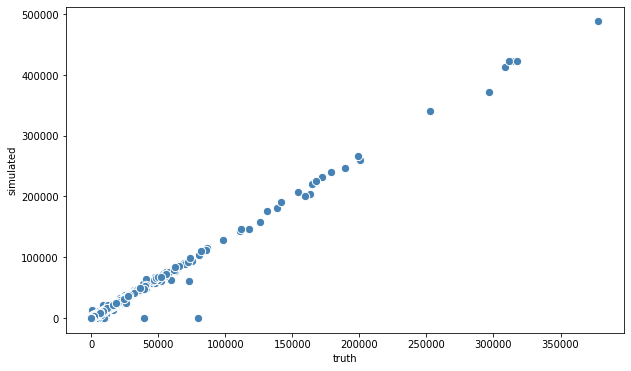

In [12]:
plt.figure(figsize=(10,6))

# X = dfr
# y = dfsim

X = dfr['expected_count_real']
y = dfsim['expected_count_sim']
plt.scatter(X,y,c='steelblue', edgecolor='white', s=70)
# plt.xlim(0, 50000)

plt.xlabel('truth')
plt.ylabel('simulated')
plt.savefig('scatter for simulated and truth.png')
plt.show()


### Simple linear regression with scikit-learn

Next, I perform a linear regression analysis using the `scikit-learn` machine-learning library in Python. The linear regression analysis helps to look for a relationship in the data. Here we are interested to see whether the distribution of the real data is similar to the simulated data which will be an indication of the performance of the expression profiling feature in the RSDS tool. Linear regression is most effective for building predictive models but we are interested in using the technique to statistically evaluate the relationship between simulated and the real data if any exist. 

In [13]:
# re-shape dataset
X = np.array(X).reshape(-1, 1)
y = np.array(y).reshape(-1, 1)
# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(X, y)
# Predict
y_predicted = regression_model.predict(X)

In [14]:
# model evaluation
rmse = mean_squared_error(y, y_predicted)
r2 = r2_score(y, y_predicted)
r2

0.9923785954119677

In [15]:
# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[1.30340714]]
Intercept: [-1.49200388]
Root mean squared error:  256720.34164977568
R2 score:  0.9923785954119677


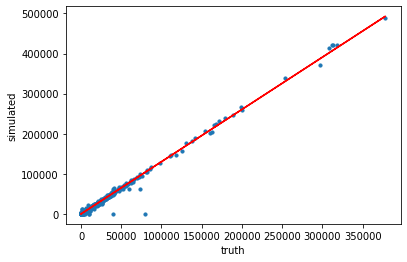

In [16]:
 #plotting values

# data points
plt.scatter(X, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.xlabel('truth')
plt.ylabel('simulated')
# predicted values
plt.plot(X, y_predicted, color='r')
plt.savefig('regression line.png')
plt.show()

Text(0, 0.5, 'Residual')

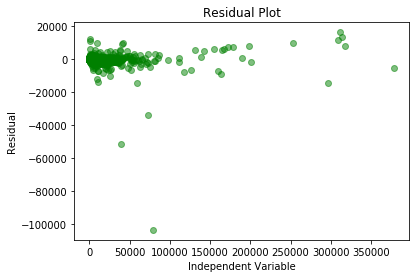

In [17]:
residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='g', alpha=0.5)
plt.title("Residual Plot")
plt.xlabel("Independent Variable")
plt.ylabel("Residual")

# plt.savefig('residual plot1.png')


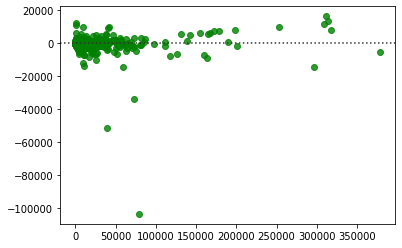

In [18]:
sns.residplot(x=X, y=y, lowess=False, color="g")
plt.savefig('residual plot 2.png')

In [19]:
import statsmodels.api as sm
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())
plt.savefig('OLS regression results.png')

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          1.004e+07
Date:                Tue, 08 Jun 2021   Prob (F-statistic):                        0.00
Time:                        11:26:56   Log-Likelihood:                     -5.8247e+05
No. Observations:               76172   AIC:                                  1.165e+06
Df Residuals:                   76171   BIC:                                  1.165e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<Figure size 432x288 with 0 Axes>

In [ ]:
# Remove all data that have 0 values in the expected count columns of both dataframes.
# Merge the two dataframes to remove all rows that does not match between the dataframes.

In [ ]:
influence = est2.get_influence()
inf_sum = influence.summary_frame()
print(inf_sum.head())



Leverage vs. Studentized Residuals


/home/darryn/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


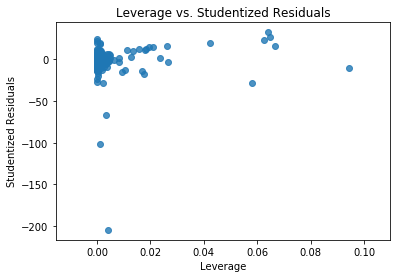

In [22]:
student_resid = influence.resid_studentized_external
# print(type(student_resid))
# studmax = student_resid.max()
# print(studmax)
# res = np.where(student_resid[student_resid == studmax])
# print(res)
# # print(len(res))
# # print(res)
(cooks, p) = influence.cooks_distance
cm = cooks.max()
# print(cm)
(dffits, p) = influence.dffits
leverage = influence.hat_matrix_diag
print ('\n')
print ('Leverage vs. Studentized Residuals')
sns.regplot(leverage, est2.resid_pearson,  fit_reg=False)
res = est2.resid_pearson.max()
# print(len(res))
# print(res)
plt.title('Leverage vs. Studentized Residuals')
plt.xlabel('Leverage')
plt.ylabel('Studentized Residuals')
plt.savefig('Leverage vs studentized residuals.png')

In [23]:
dfr['student_resid'] = student_resid.tolist()
# dfr['cooks_dist'] = cooks_d.tolist()
dfr.head()


,transcript_id,gene_id_real,length_real,effective_length_real,expected_count_real,TPM_real,FPKM_real,IsoPct_real,student_resid
0,ENST00000373020.8,ENSG00000000003.14,2206,2033.35,10.00,0.16,0.13,100.00,0.007828
1,ENST00000371584.8,ENSG00000000419.12,1073,900.35,61.01,2.14,1.80,21.72,-0.041384
2,ENST00000371588.9,ENSG00000000419.12,1075,902.35,164.28,5.76,4.83,58.36,0.035016
3,ENST00000413082.1,ENSG00000000419.12,672,499.43,18.08,1.15,0.96,11.60,0.015661
4,ENST00000466152.5,ENSG00000000419.12,1097,924.35,14.65,0.50,0.42,5.08,-0.027639


In [24]:
dfsim['student_resid'] = student_resid.tolist()
# dfr['cooks_dist'] = cooks_d.tolist()
dfsim.head()

,transcript_id,gene_id_sim,length_sim,effective_length_sim,expected_count_sim,TPM_sim,FPKM_sim,IsoPct_sim,student_resid
0,ENST00000373020.8,ENSG00000000003.14,2206,2027.98,17.00,0.21,0.17,100.00,0.007828
1,ENST00000371584.8,ENSG00000000419.12,1073,894.98,58.55,1.66,1.34,16.64,-0.041384
2,ENST00000371588.9,ENSG00000000419.12,1075,896.98,231.86,6.56,5.31,65.74,0.035016
3,ENST00000413082.1,ENSG00000000419.12,672,494.35,31.50,1.62,1.31,16.21,0.015661
4,ENST00000466152.5,ENSG00000000419.12,1097,918.98,5.09,0.14,0.11,1.41,-0.027639


In [25]:
dfrs = dfr.sort_values('student_resid', ascending=True)
dfrs.head()

,transcript_id,gene_id_real,length_real,effective_length_real,expected_count_real,TPM_real,FPKM_real,IsoPct_real,student_resid
72614,ENST00000582401.5,ENSG00000265972.5,2926,2753.35,79533.72,914.20,767.02,93.45,-306.216469
35918,ENST00000360270.6,ENSG00000147065.16,3944,3771.35,39585.88,332.20,278.71,99.58,-109.621701
37428,ENST00000339647.5,ENSG00000150991.14,2688,2515.35,72888.06,917.08,769.44,94.29,-69.388243
67178,ENST00000412585.6,ENSG00000234745.10,1547,1374.35,296702.52,6832.40,5732.42,62.53,-29.149712
33672,ENST00000338257.12,ENSG00000142347.16,4303,4130.35,59200.95,453.62,380.59,62.63,-28.925384


In [26]:
dfsims = dfsim.sort_values('student_resid', ascending=True)
dfsims.head()

,transcript_id,gene_id_sim,length_sim,effective_length_sim,expected_count_sim,TPM_sim,FPKM_sim,IsoPct_sim,student_resid
72614,ENST00000582401.5,ENSG00000265972.5,2926,2747.98,3.37,0.03,0.03,0.05,-306.216469
35918,ENST00000360270.6,ENSG00000147065.16,3944,3765.98,1.00,0.01,0.01,0.54,-109.621701
37428,ENST00000339647.5,ENSG00000150991.14,2688,2509.98,60963.06,615.97,498.51,63.28,-69.388243
67178,ENST00000412585.6,ENSG00000234745.10,1547,1368.98,372457.77,6899.85,5584.18,71.64,-29.149712
33672,ENST00000338257.12,ENSG00000142347.16,4303,4124.98,62601.40,384.88,311.49,46.93,-28.925384


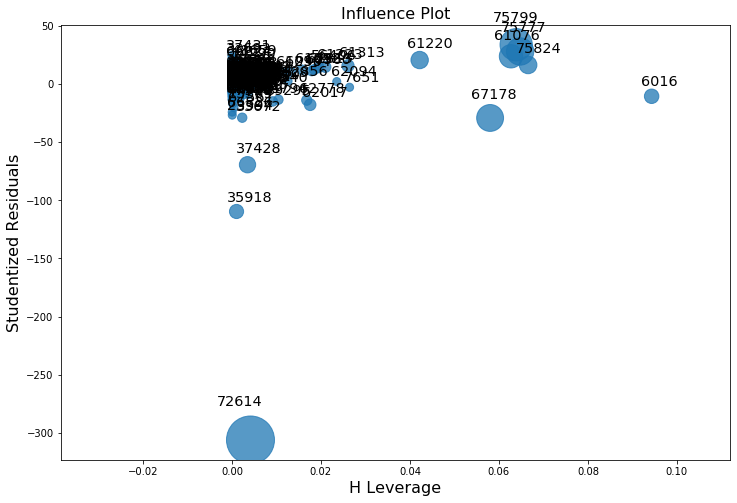

In [27]:
fig, ax = plt.subplots(figsize=(12,8))

fig = sm.graphics.influence_plot(est2, ax= ax, criterion="cooks", alpha = 0.5)
